# Температура обработки стали. Построение регрессионной модели.

<a name="1common."></a>
## <a name="0.0"></a>Содержание:
* [Подгрузка библиотек и самописные функции](#0.)
* [Загрузка данных](#1.)
* [Часть 1.Исследовательский анализ данных](#8.)
    * [Данные об электродах](#2.)
    * [Данные о подаче сыпучих материалов (объём, время подачи)](#3.)
    * [Данные данные о продувке сплава газом](#4.)
    * [Данные о проволочных материалах (объём, время)](#5.)
    * [Результаты измерения температуры](#6.)
    * [Список уточняющих вопросов и Примерный план решения задачи.](#7.)
* [Часть 2. Код решения](#9.)
    * [Чистка данных](#10.)
    * [Подготовка данных для модели](#11.)
    * [Построение модели](#12.)
    * [Тестирование модели](#13.)
    * [Проверка модели на адекватность](#14.)
* [Вывод](#15.)

## Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали, для этого необходимо построить модель предскаазывающую температуру стали.

### Описание данных


https://data.gov.lt/datasets/500/

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

## Подгрузка библиотек и самописные функции
<a name="0."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [1]:
import pandas as pd
import numpy as np
import time

import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored

import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.exceptions import NotFittedError

from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import IsolationForest

#Убираем ворнинги
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning

%config InlineBackend.figure_format='retina'
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction import DictVectorizer
from numpy import asarray

from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [3]:
#Определяем болд
def bold(): 
    return "\033[1m"

def bold_end(): 
    return "\033[0m"

#Ставим формат для нумериков
pd.options.display.float_format = '{: >10.2f}'.format

In [4]:
#**Функция print_basic_info, для вывода информации о массиве, и его переменных.**

#* base - название базы данных
#* info - 1: вывод информации о массиве, другое: не вывод
#* describe - 1: вывод описания переменных массива, другое: не вывод        
#* duplicat - 1: вывод количества полных дублей
#* head - n: вывод примера базы (вывод n - строк), n < 1: не вывод

def print_basic_info(base, info, describe, duplicat, head):
    if info == 1:
        print("\n", bold(), colored('info','green'), bold_end(), "\n")
        print( base.info())  
    if head >= 1:
        print("\n", bold(),colored('head','green'),bold_end())
        display(base.head(head))
    if describe == 1:
        print("\n", bold(),colored('describe','green'),bold_end(),"\n")
        for i in base.columns:
            print("\n", bold(), colored(i,'blue'),bold_end(),"\n", base[i].describe())
    if duplicat == 1:
        print("\n", bold(),colored('duplicated','green'),bold_end(),"\n")
        print(base[base.duplicated() == True][base.columns[0]].count())

## Загрузка данных
<a name="1."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [5]:
data_averages = pd.read_csv('datasets/Averages.csv', sep=',',decimal='.')
data_quantity = pd.read_csv('datasets/Quantity.csv', sep=',',decimal='.')
data_quantity_units = pd.read_csv('datasets/QuantityUnits.csv', sep=',',decimal='.')
data_station = pd.read_csv('datasets/Station.csv', sep=',',decimal='.')

<!-- # data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
# data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
# data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
# data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
# data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
# data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
# data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv') -->

## Исследовательский анализ данных
<a name="8."></a>
[<font size="2">(к содержанию)</font>](#1common.)

### Данные об электродах (data_arc)
<a name="2."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [6]:
#данные об электродах;
print_basic_info(data_averages,1,1,1,5)


  info  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627777 entries, 0 to 2627776
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   _type         object 
 1   _id           object 
 2   _revision     object 
 3   id            int64  
 4   stat_num._id  object 
 5   ldatetime     object 
 6   code_combi    int64  
 7   lvalue        float64
 8   atribut       int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 180.4+ MB
None

  head 


,_type,_id,_revision,id,stat_num._id,ldatetime,code_combi,lvalue,atribut
0,datasets/gov/aaa/oro_stociu_matavimai/Averages,ffc91117-d74c-411b-b579-6006f6343124,fe9212e8-524f-4771-884c-f37c4c520ce1,100013482,f15078a3-c648-4ef2-93eb-9d2e473fffba,2012-12-11T13:00:00,401,8.23,1
1,datasets/gov/aaa/oro_stociu_matavimai/Averages,7c1a9813-4831-46a5-ab6c-6dd750ecb0a3,4d74d0ae-0cf6-40bf-bee1-f2afaa5ef962,100013570,f15078a3-c648-4ef2-93eb-9d2e473fffba,2012-12-11T20:00:00,906,993.06,1
2,datasets/gov/aaa/oro_stociu_matavimai/Averages,8f325751-c286-44f5-a27a-e16c72b0c6fc,cb99870b-f52d-487c-ac17-32b3fbd95381,100171317,6bd59444-5437-447d-bc2d-c32ef5b0a964,2012-12-12T08:00:00,5301,-0.55,1
3,datasets/gov/aaa/oro_stociu_matavimai/Averages,0fa048e3-5004-49c8-a3f9-ffdffc57b934,e7eca78b-c7e5-4f5c-ad8f-24db108ad0c7,100185170,f15078a3-c648-4ef2-93eb-9d2e473fffba,2012-12-12T08:00:00,906,995.97,1
4,datasets/gov/aaa/oro_stociu_matavimai/Averages,aa414bf9-0821-4061-910b-19d4bb395009,4e1d3552-e06a-4b61-b758-15d123df2091,100353357,6bd59444-5437-447d-bc2d-c32ef5b0a964,2012-12-13T02:00:00,7001,0.00,1



  describe  


  _type  
 count                                            2627777
unique                                                 1
top       datasets/gov/aaa/oro_stociu_matavimai/Averages
freq                                             2627777
Name: _type, dtype: object

  _id  
 count                                  2627777
unique                                 2627777
top       ffc91117-d74c-411b-b579-6006f6343124
freq                                         1
Name: _id, dtype: object

  _revision  
 count                                  2627777
unique                                 2627777
top       fe9212e8-524f-4771-884c-f37c4c520ce1
freq                                         1
Name: _revision, dtype: object

  id  
 count     2627777.00
mean    351406264.52
std     206039965.19
min        722313.00
25%     125469720.00
50%     398467385.00
75%     520119327.00
max     680955116.00
Name: id, dtype: float64

  stat_num._id  
 count                                  

KeyboardInterrupt: 

In [ ]:
#данные об электродах;
print_basic_info(data_quantity,1,1,1,5)

In [ ]:
#данные об электродах;
print_basic_info(data_quantity_units,1,1,1,5)

In [ ]:
#данные об электродах;
print_basic_info(data_station,1,1,1,5)

* Всего 14876. Пропусков нет.
* Полных дублей нет.
* Уникальных ключей всего 3214. Значит было несколько последовательных нагревов.
Что с этим делать? Помимо среднего времени нагрева и мощностей можно посчитать количество нагревов.
* Минусовая реактивная мощность? Если единичный случай - удалим.
* Как соотносится активная и реактивная энергия? Сравним.

### Список уточняющих вопросов и Примерный план решения задачи.  
<a name="7."></a>
[<font size="2">(к содержанию)</font>](#1common.)

#### Список уточняющих вопросов.

* **Почистить данные:**
    * Где необходимо посчитать информацию по партиям и объединить данные в одну базу.
    * Оставить только необходимые столбцы, в том числе, чтобы не было недоступной в реальных случаях информации (утечек).
    
    
* **Подготовить данные для модели:**
    * Разделение дата сета на тестовый и тренинговый/валидационный.
    * Проверить на аномалии (например методом изоляционных деревьев). Посмотреть объем и принять решение об исключении их из тренировочного датасета.


* **Построить модели:**
    * Выявить пулл подходов учитывающий возможные ограничения и найти регрессионную модель удовлетворяющую необходимым характеристикам. 
    * Проверить модель на адекватность.

## Код решения
<a name="9."></a>
[<font size="2">(к содержанию)</font>](#1common.)

### Чистка данных
<a name="10."></a>
[<font size="2">(к содержанию)</font>](#1common.)

* Где необходимо посчитать информацию по партиям и объединить данные в одну базу.
* Оставить только необходимые столбцы, в том числе, чтобы не было недоступной в реальных случаях информации (утечек).

Сначала поймем какие кейсы мы берем в работу. Для этого необходимо найти первую и последнюю температуру и сравнить их по времени.<br>
Выкидываем если время это одинаковое (а значит был только один замер).

Больше всего влияет информация о первичной температуре, время нагрева и сила тока.
<!-- #попробуем их перемножить, чтобы сделать новую фичу
data_united['temp_power'] = data_united.start_temp * data_united.mean_active_power * data_united.mean_reactive_power -->

In [7]:
data = data_averages.merge(data_quantity_units,how='left', on = 'code_combi')

data.groupby(by="code_unit._id", dropna=False)['lvalue'].mean()

data['datetime'] = pd.to_datetime(data.ldatetime)
data['year'] = data.datetime.dt.year
data['month'] = data.datetime.dt.month
data['week'] = data.datetime.dt.week
data['weekday'] = data.datetime.dt.weekday
data['day'] = data.datetime.dt.day
data = data[data['year']== 2023]
data =data[data['code_unit._id'] == '67461e7c-506e-430a-8962-cd25ebed54da']
d_q = data_quantity[data_quantity['code_unit._id'] == '67461e7c-506e-430a-8962-cd25ebed54da'] 
data_quantity['code_unit._id'].value_counts()

28f650e6-08d2-4311-98fe-55cc2aba9ff0    45
2b1b3b00-a4d3-4ea4-9dff-92374f6fc07b     9
89a0ce55-265d-4266-91ea-5eb0ed25b77b     6
bb00bdc2-70d3-4b20-a584-1586c8c1d267     5
f24213b6-172a-47b8-960c-be177c547eee     4
0fc540c4-cae8-4557-a091-6e310dd8d095     3
48518a60-6e96-4b6f-93b8-bcaeff67685a     3
85e37543-6901-475a-83e1-0647bbd4b2bc     2
866e2570-2343-40fa-b0e7-999c75f9a46e     2
8b8b188a-4344-4c05-8fe9-39b73e8d5915     2
ce869cdc-5213-4728-96ef-a3a78b62a18b     2
8da58da5-dedc-4c8d-b799-3714f527c322     2
4797ee11-9fda-4178-930f-13ad3ae435a6     1
30b66260-1510-456e-9d8b-50179126b543     1
8fd74243-e9d1-430d-9ad5-5bccd2288be3     1
67461e7c-506e-430a-8962-cd25ebed54da     1
Name: code_unit._id, dtype: int64

In [9]:
data = data.merge(d_q,how='left', on = 'code_unit._id')
data_station['stat_num._id'] = data_station['_id']
data = data.merge(data_station,how='left', on = 'stat_num._id')
data

,_type_x,_id_x,_revision_x,id_x,stat_num._id,ldatetime,code_combi,lvalue,atribut,_type_y,...,shortname_y,longname_y,attrib_y,id,_type_y,_id_y,_revision_y,stat_num_y,latitude_y,longitude_y
0,datasets/gov/aaa/oro_stociu_matavimai/Averages,6081a1af-d3d7-46ff-a83e-e0da6e5191f3,02655ba4-e7ee-47d5-814d-683b1821ab15,652315134,f15078a3-c648-4ef2-93eb-9d2e473fffba,2023-01-04T21:00:00,906,984.48,1,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f15078a3-c648-4ef2-93eb-9d2e473fffba,051fab6f-10b2-4774-b65b-fc7098ef82fe,53,56.01,21.89
1,datasets/gov/aaa/oro_stociu_matavimai/Averages,32f0fcf6-9bae-42e5-8fe7-45b69fec3115,d1f06dbf-7c48-414c-bd20-63483ec399f8,653958314,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-01-14T02:00:00,906,991.37,1,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00
2,datasets/gov/aaa/oro_stociu_matavimai/Averages,12a28f39-cd4d-4d97-8268-5a88d2b449ba,dd70eb87-4a77-4227-8d21-2532ad8a24e1,653958468,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-01-15T00:00:00,906,994.53,1,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00
3,datasets/gov/aaa/oro_stociu_matavimai/Averages,73a054c6-4d3e-482f-8597-569c4012165e,85af44b6-d331-4c2c-a668-d9f9d151e908,654441235,ef4fb1da-264d-42f8-893f-e9e3b1f6b2d9,2023-01-17T20:00:00,906,984.95,1,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,ef4fb1da-264d-42f8-893f-e9e3b1f6b2d9,aa4d9094-dcb2-488d-b6b6-97c128a9a4ff,52,54.09,24.29
4,datasets/gov/aaa/oro_stociu_matavimai/Averages,e5143f3c-88f0-496c-92cb-d246c80e34df,bcaafd70-904f-421d-b8de-aef39f7648ba,654774141,f15078a3-c648-4ef2-93eb-9d2e473fffba,2023-01-19T06:00:00,906,980.80,1,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f15078a3-c648-4ef2-93eb-9d2e473fffba,051fab6f-10b2-4774-b65b-fc7098ef82fe,53,56.01,21.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15647,datasets/gov/aaa/oro_stociu_matavimai/Averages,32a05967-e722-4a82-9036-c0dab572d66d,a7223c28-2956-4a8c-a2cb-92976c6b81bc,680802328,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-10-10T11:00:00,906,999.80,1,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00
15648,datasets/gov/aaa/oro_stociu_matavimai/Averages,3de84c66-55ab-4b06-a907-db0d554b2a03,0637591a-5701-4f18-b3d7-ec928af6581f,680802335,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-10-10T12:00:00,906,1000.00,1,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00
15649,datasets/gov/aaa/oro_stociu_matavimai/Averages,d85fb434-9679-4605-86c3-72e289343ce4,7c3aad47-a599-461f-82ac-fe8ba6b5cf14,680802363,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-10-10T16:00:00,906,1000.18,1,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9-a70a8bb41f7b,295f1729-3f12-42d4-af54-56162c74a112,51,55.46,26.00
15650,datasets/gov/aaa/oro_stociu_matavimai/Averages,a143a44a-e64c-4ba9-8412-1d10650a8008,c088e072-c0f6-45ef-ae84-07e8d4c2d896,680802370,f7636a52-2e03-43da-83d9-a70a8bb41f7b,2023-10-10T17:00:00,906,1000.02,1,datasets/gov/aaa/oro_stociu_matavimai/Quantity...,...,PRES,atm. pressure,meteo,9,datasets/gov/aaa/oro_stociu_matavimai/Station,f7636a52-2e03-43da-83d9

 % mean in test sample: target 999.36


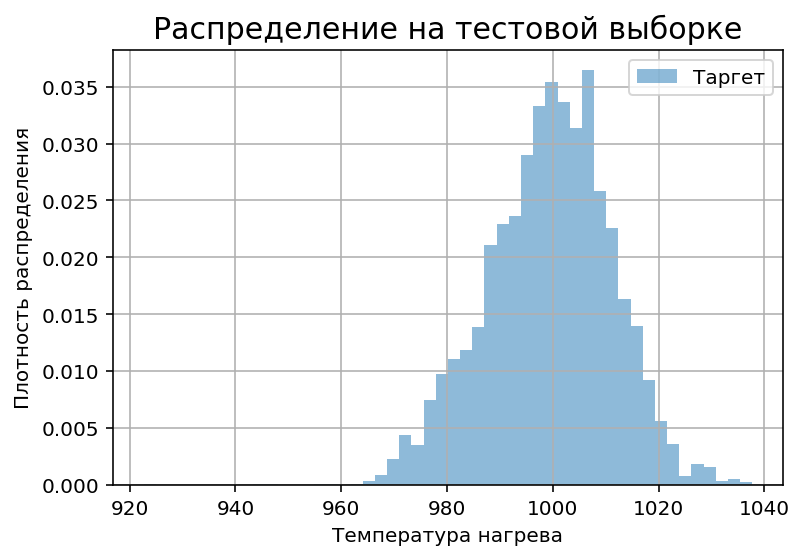

In [52]:
#**Проверка на логичность**
print(bold(),"% mean in test sample: target",colored(round(data['lvalue'].mean(),2),'blue'))

data['lvalue'].hist(bins = 50, alpha=0.5, density=True)

plt.xlabel('Температура нагрева')
plt.ylabel('Плотность распределения')
plt.title('Распределение на тестовой выборке', fontsize=15) 
plt.legend(['Таргет', 'Предсказания'])
plt.show()

In [53]:
data['lvalue'].quantile(0.05)

978.5599975586

In [54]:
data['lvalue'].quantile(0.95)

1017.4000244141

In [51]:
data = data[data['lvalue'] > 800]

In [55]:

data['lvalue'].mean()

data.columns

data = data[['lvalue','stat_num._id','stat_num','code_quantity._id','year','month','week','weekday','day','latitude','longitude']]

In [56]:
print_basic_info(data,1,1,1,5)


  info  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14916 entries, 0 to 15651
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lvalue             14916 non-null  float64
 1   stat_num._id       14916 non-null  object 
 2   stat_num           14916 non-null  int64  
 3   code_quantity._id  14916 non-null  object 
 4   year               14916 non-null  int64  
 5   month              14916 non-null  int64  
 6   week               14916 non-null  int64  
 7   weekday            14916 non-null  int64  
 8   day                14916 non-null  int64  
 9   latitude           14896 non-null  float64
 10  longitude          14896 non-null  float64
dtypes: float64(3), int64(6), object(2)
memory usage: 1.4+ MB
None

  head 


,lvalue,stat_num._id,stat_num,code_quantity._id,year,month,week,weekday,day,latitude,longitude
0,984.48,f15078a3-c648-4ef2-93eb-9d2e473fffba,53,c07dc73f-feb0-4f78-aeb8-617ee8d4d09f,2023,1,1,2,4,56.01,21.89
1,991.37,f7636a52-2e03-43da-83d9-a70a8bb41f7b,51,c07dc73f-feb0-4f78-aeb8-617ee8d4d09f,2023,1,2,5,14,55.46,26.00
2,994.53,f7636a52-2e03-43da-83d9-a70a8bb41f7b,51,c07dc73f-feb0-4f78-aeb8-617ee8d4d09f,2023,1,2,6,15,55.46,26.00
3,984.95,ef4fb1da-264d-42f8-893f-e9e3b1f6b2d9,52,c07dc73f-feb0-4f78-aeb8-617ee8d4d09f,2023,1,3,1,17,54.09,24.29
4,980.80,f15078a3-c648-4ef2-93eb-9d2e473fffba,53,c07dc73f-feb0-4f78-aeb8-617ee8d4d09f,2023,1,3,3,19,56.01,21.89



  describe  


  lvalue  
 count     14916.00
mean        999.36
std          11.73
min         922.63
25%         991.60
50%        1000.05
75%        1007.34
max        1037.74
Name: lvalue, dtype: float64

  stat_num._id  
 count                                    14916
unique                                      18
top       ef4fb1da-264d-42f8-893f-e9e3b1f6b2d9
freq                                      5320
Name: stat_num._id, dtype: object

  stat_num  
 count     14916.00
mean         51.34
std           5.63
min           1.00
25%          51.00
50%          52.00
75%          53.00
max          99.00
Name: stat_num, dtype: float64

  code_quantity._id  
 count                                    14916
unique                                       1
top       c07dc73f-feb0-4f78-aeb8-617ee8d4d09f
freq                                     14916
Name: code_quantity._id, dtype: object

  year  
 count     14916.00
mean       2023.00
std           0.00
min        2023.00
25%        202

In [58]:
data = data.drop_duplicates()

### Подготовка данных для модели
<a name="11."></a>
[<font size="2">(к содержанию)</font>](#1common.)

* Разделение дата сета на тестовый и тренинговый/валидационный.
* Проверить на аномалии (например методом изоляционных деревьев). Посмотреть объем и принять решение об исключении их из тренировочного датасета.

In [59]:
#выделим таргет
features, target = data.drop(['lvalue'], axis=1), data['lvalue']
features = features.fillna(0)

#разбиваем на train и тест (25%)
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.10, shuffle=False
                                                                           )

<!-- # #Масштабируем признаки
# numeric = features_train.columns

# scaler = StandardScaler()
# scaler.fit(features_train[numeric])

# features_train[numeric] = scaler.transform(features_train[numeric])
# features_test[numeric] = scaler.transform(features_test[numeric])

# display(features_train.head())

# from sklearn.cluster import KMeans


# clustering = KMeans(n_clusters=5, random_state=515093).fit(features_train)

# features_train['clustering'] = clustering.predict(features_train)
# features_test['clustering'] = clustering.predict(features_test) -->
Посмотрим сколько осталось нетипичных случаев

In [60]:
scaler = MinMaxScaler()

scaler.fit(asarray(features_train[['latitude','longitude']]))

features_train[['latitude','longitude']] = scaler.transform(asarray(features_train[['latitude','longitude']]))
features_test[['latitude','longitude']] = scaler.transform(asarray(features_test[['latitude','longitude']]))

In [61]:
train_dicts = features_train.to_dict(orient='records')
val_test = features_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_test = dv.transform(val_test)

Немного кейсов. Удалять не будем.


### Построение модели
<a name="12."></a>
[<font size="2">(к содержанию)</font>](#1common.)
    
* Выявить пулл подходов учитывающий возможные ограничения и найти регрессионную модель удовлетворяющую необходимым характеристикам. 
* Проверить модель на адекватность.

Возьмем самые привлекательные по RSME и попробудем подобрать лушие параметры.

In [62]:
#разделим на фолдеры 
cv = TimeSeriesSplit(n_splits=3)

In [63]:
#RandomForestClassifier

grid = {'max_depth' : [i for i in np.arange(12,20)]}

clf = RandomForestRegressor()

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')

# временно закоментим для сокращения времени расчета
gs.fit(X_train,target_train)

RandomForestRegressor_params = gs.best_params_
print(RandomForestRegressor_params)

{'max_depth': 18}


In [69]:
#XGBRegressor

grid = {'eta' : [i for i in np.arange(0.1,0.3,0.1)] , 'max_depth' : [i for i in np.arange(14,20)]}

clf = XGBRegressor(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')

# временно закоментим для сокращения времени расчета
gs.fit(X_train,target_train)

XGBRegressor_best_params = gs.best_params_
print(XGBRegressor_best_params)

{'eta': 0.1, 'max_depth': 19}


In [67]:
#GradientBoostingRegressor

grid = { 'loss' : ['ls'],
        'learning_rate' : [i for i in np.arange(0.1,0.4,0.1)] , 
        'max_depth' : [i for i in np.arange(12,17,1)]}

clf = GradientBoostingRegressor(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')

# временно закоментим для сокращения времени расчета
gs.fit(X_train,target_train)

GradientBoostingRegressor_best_params = gs.best_params_
print(GradientBoostingRegressor_best_params)

{'learning_rate': 0.2, 'loss': 'ls', 'max_depth': 12}


In [68]:
#LGBMRegressor

grid = { 'learning_rate' : [i for i in np.arange(0.1,0.3,0.1)]}

clf = LGBMRegressor(random_state = 123)

gs = GridSearchCV(clf, grid, cv=cv, scoring = 'neg_mean_absolute_error')

# временно закоментим для сокращения времени расчета
gs.fit(X_train,target_train)

LGBMRegressor_best_params = gs.best_params_
print(LGBMRegressor_best_params)

{'learning_rate': 0.2}


In [28]:
#сделаем фунукцию, котрая будет записывать время обучения, скорость предсказания, и качество предсказания
def put_in_base(model_name, base_res, features_train, target_train):
    #features_train.reset_index(drop = True, inplace = True)
    target_train.reset_index(drop = True, inplace = True)
    cv = TimeSeriesSplit(n_splits=3)
    time_train, time_predict, MAE = [], [], []
    for train_index, val_index in cv.split(features_train):
        X_train, X_val = features_train[train_index], features_train[val_index]
        y_train, y_val = target_train.loc[train_index], target_train.loc[val_index]
        #время обучения.
        start_time = time.time()
        model_name.fit(X_train, y_train)
        time_train.append(round((time.time() - start_time),3))
        #скорость предсказания.
        start_time = time.time()
        predictions_valid = model_name.predict(X_val)
        time_predict.append(round((time.time() - start_time),3))
        #качество предсказания(MAE)
        MAE.append(mean_absolute_error(y_val, predictions_valid))
    
    if len((str(clf).split('(')[0]).split('.')) == 1:
        base_res.loc[str(clf).split('(')[0],'time_train'] = np.mean(time_train)
        base_res.loc[str(clf).split('(')[0],'time_predict'] = np.mean(time_predict)
        base_res.loc[str(clf).split('(')[0],'MAE'] = np.mean(MAE)
    else:
        nm = ((str(clf).split('(')[0]).split('.')[2]).split(' ')[0]
        base_res.loc[nm,'time_train'] = np.mean(time_train)
        base_res.loc[nm,'time_predict'] = np.mean(time_predict)
        base_res.loc[nm,'MAE'] = np.mean(MAE)
        
    return base_res

In [70]:
#запустим ее для ниших моделей с ранее найденными параметрами
ans = pd.DataFrame()

for clf in (LinearRegression(),RandomForestRegressor(max_depth = 18),
            XGBRegressor(eta = 0.1, max_depth = 19, random_state = 123),
            GradientBoostingRegressor(learning_rate = 0.2, loss = 'ls', max_depth = 12, random_state = 123),
            LGBMRegressor(learning_rate = 0.2, random_state = 123),

            #деревья достаточно неплохо заходят. Значит можно попробовать и добавить CatBoostRegressor 
            CatBoostRegressor(random_state = 123, verbose=False)
           ):
    put_in_base(clf, ans, X_train,target_train)

In [71]:
display(ans.sort_values(by = 'MAE'))

,time_train,time_predict,MAE
GradientBoostingRegressor,1.93,0.04,2.85
RandomForestRegressor,1.09,0.06,2.88
XGBRegressor,2.09,0.02,2.92
CatBoostRegressor,6.53,0.03,2.94
LGBMRegressor,1.44,0.02,3.07
LinearRegression,0.03,0.00,12738.19


Лучше всего себя показал катбус. Сможем ли уменьшить количество параметров?

### Тестирование
<a name="13."></a>
[<font size="2">(к содержанию)</font>](#1common.)

In [72]:
#сделаем фунукцию, котрая будет записывать время обучения, скорость предсказания, и качество предсказания(RMSE)
def put_in_base_test(model_name, base_res, features_train, target_train, features_test, target_test):
    
    #время обучения.
    start_time = time.time()
    model_name.fit(features_train, target_train)
    
    if len((str(model_name).split('(')[0]).split('.')) == 1:
        nm = str(model_name).split('(')[0]
    else:
        nm = ((str(model_name).split('(')[0]).split('.')[2]).split(' ')[0]

    base_res.loc[nm,'time_train'] = round((time.time() - start_time),3)
    #скорость предсказания.
    start_time = time.time()
    predictions_test = model_name.predict(features_test)
    base_res.loc[nm,'time_predict'] = round((time.time() - start_time),3)
    #качество предсказания(mae)
    base_res.loc[nm,'MAE'] = mean_absolute_error(target_test, predictions_test)
    
    return predictions_test, model_name, base_res

In [73]:
#посмотрим на результат
info_final_test = pd.DataFrame()

final_model = GradientBoostingRegressor(learning_rate = 0.2, loss = 'ls', max_depth = 12, random_state = 123)

predictions_test, final_model, info_final_test = put_in_base_test(final_model, info_final_test, 
                                                                  X_train, target_train, 
                                                                  X_test, target_test)

In [74]:
#выведем красиво
colors = ['rgb(107, 174, 214)']
fig = go.Figure(data=[go.Table( header=dict(
    values=['Время обучения модели (в секундах)', 
            'Время предсказания модели (в секундах)',
            'MAE на тестовой выборке'],
    line_color='white', fill_color='white',
    align='center', font=dict(color='black', size=15)
  ),
  cells=dict(
    values=[info_final_test.time_train.round(2), 
            info_final_test.time_predict.round(2),info_final_test.MAE.round(2)],
    line_color=[colors], fill_color=[colors],
    align='center', font=dict(color='black', size=14)
  ))
])
fig.update_layout(title_text="Показатели финальной модели (GradientBoostingRegressor)", height = 300)
fig.show()

#### Проверка модели на адекватность.
<a name="14."></a>
[<font size="2">(к содержанию)</font>](#1common.)

 % mean in test sample: target 945.11 VS predictions 943.97 


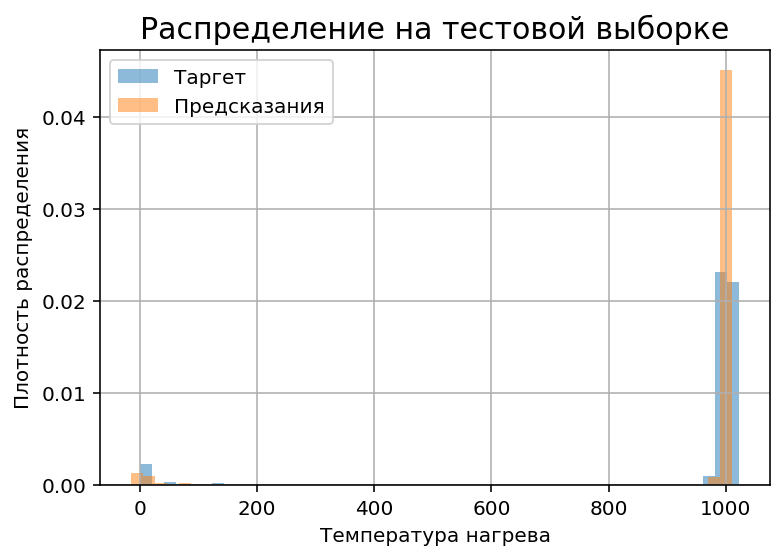

In [38]:
#**Проверка на логичность**
print(bold(),"% mean in test sample: target",colored(round(target_test.mean(),2),'blue')+bold(),"VS predictions",
      colored(round(predictions_test.mean() ,2),'blue'),bold_end())

target_test.hist(bins = 50, alpha=0.5, density=True)
pd.Series(predictions_test).hist(bins = 50, alpha=0.5, density=True)

plt.xlabel('Температура нагрева')
plt.ylabel('Плотность распределения')
plt.title('Распределение на тестовой выборке', fontsize=15) 
plt.legend(['Таргет', 'Предсказания'])
plt.show()

Средние похожи. Распределения также, однако предсказание ожидаемо хуже определяет крайние случаи

In [ ]:
#Сравнимc дамми
dummy_model = DummyRegressor(strategy='median')

predictions_dummy, dummy_model, info_final_test = put_in_base_test(dummy_model, info_final_test, 
                                                                  features_train, target_train, 
                                                                  features_test, target_test)

In [ ]:
display(info_final_test)

Наша модель показывает себя гораздно лучше чем Дамми

## Вывод.
<a name="15."></a>
[<font size="2">(к содержанию)</font>](#1common.)

**На основе исторических данных, была построена модель для предсказания финальной температуру стали с целью оптимизировать производственные расходы, металлургического комбината и уменьшить потребление электроэнергии на этапе обработки стали.**

**Заказчику необходима модель с показателем MAE не более 8.7:**
* Полученная модель имеет на тестовой выборке МАЕ 5.43 

По результатам первичного анализа и в работу взяты:
* Кейсы содержащие минимум 2 замера температуры (первичный и окончательный).
* Кейсы с последним замером температуры после окончания нагревания дугой.

**Модель построена на основе данных о партиях на производстве*:**

* 'start_temp' - первичное измерение температуры
* 'full_time' - сколько прошло от начала первого нагревания дугой до окончания последнего
* 'count' - количество нагреваний дугой
* 'sum_arc_heating_seconds' - суммарное время нагрева дугой
* 'mean_reactive_power' - средняя реактивная мощность в процессе нагревания(в партии)
* 'ratio_active_to_reactive' - средняя соотношение активной и реактивной мощности в процессе нагревания (в партии)
* информация об объеме различных добавлений в процессе легиризации ('bulk 1','bulk 2', 'bulk 3', 'bulk 4', 'bulk 5', 'bulk 6', 'bulk 7', 'bulk 9','bulk 10', 'bulk 11', 'bulk 12', 'bulk 14', 'bulk 15', 'wire 1','wire 2', 'wire 3', 'wire 4', 'wire 6', 'wire 7', 'wire 8', 'wire 9')
* информация об объеме газа использующегося в процессе ('gaz')

***Целевой признак - Финальная температура(end_temp)***

**Модель построена с помощью CatBoostRegressor(random_state = 123):**